 **🐶 FastAI Chapter 5 – Pet Breeds: Lesson Roadmap**

`This notebook walks through the complete pipeline for training a pet breed classifier using the Oxford-IIIT dataset, as covered in FastAI's Chapter 5.`

<sub>

**📚 Lesson Topics Overview**

1. **📘 Introduction & Task Definition**  
   - Classify pet breeds from images using transfer learning

2. **📦 Download & Inspect Dataset**  
   - `untar_data(URLs.PETS)`  
   - Explore image file structure

3. **🔤 Label Extraction via Regex**  
   - Use regular expressions to get breed names from filenames

4. **🧱 Build a DataBlock**  
   - Define blocks: `ImageBlock`, `CategoryBlock`  
   - Customize: `get_items`, `get_y`, `splitter`, transforms

5. **🌀 Presizing & Data Augmentation**  
   - Use `Resize` and `aug_transforms` to speed up and diversify training

6. **🖼️ Visualize a Training Batch**  
   - `dls.show_batch()` to verify data integrity

7. **🏋️‍♂️ Train a Baseline Model**  
   - `cnn_learner` + `fine_tune()`

8. **📊 Softmax & Cross-Entropy Explanation**  
   - Understand how multi-class classification loss works

9. **📉 Inspect Logs and Plot Loss**  
   - `learn.recorder.plot_loss()` to view training dynamics

10. **🔍 Evaluate Results**  
    - `learn.show_results()` for predictions vs. actuals

11. **🧠 Model Interpretation Tools**  
    - `ClassificationInterpretation`:  
      - Confusion matrix  
      - `plot_top_losses()`  
      - `most_confused()`

12. **🔬 Learning Rate Finder**  
    - Use `learn.lr_find()` to choose optimal learning rate

13. **🔁 Fine-Tuning & Scheduling**  
    - `fit_one_cycle()` and **discriminative learning rates**

14. **🏗️ Try Deeper Backbones**  
    - Swap to `resnet50`, `resnet101`, or modern nets

15. **⚡ Mixed-Precision Training**  
    - `learn.to_fp16()` for faster, lighter training

16. **💾 Save & Load Models**  
    - `learn.save()`, `learn.export()`, `load_learner()`

17. **📝 End-of-Chapter Questionnaire**  
    - Reflective questions to deepen understanding

<sub/>


In [2]:
from fastai.vision.all import *


In [3]:
path = untar_data(URLs.PETS)/'images'

fnames = get_image_files(path)


In [4]:
import re
pat = r'([^/\\]+)_\d+.jpg$'  # works for both / and \ path separators
lbls = [re.search(pat, f.name).group(1) for f in fnames]

In [5]:
pets= DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=RegexLabeller(pat),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [6]:
dls = pets.dataloaders(path)

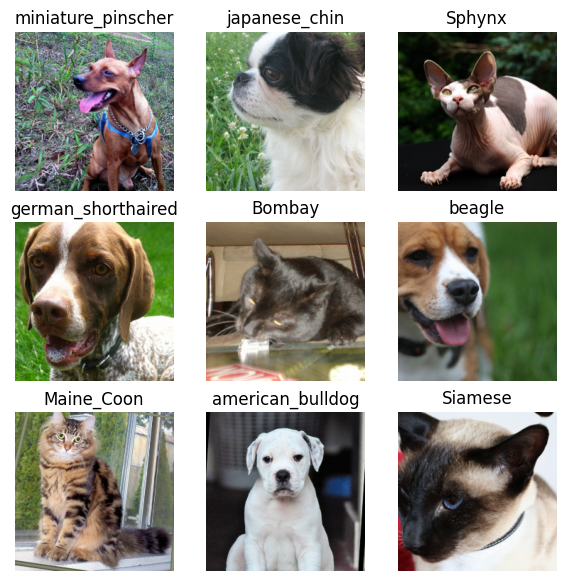

In [7]:
dls.show_batch(max_n=9, figsize=(7, 7))

In [8]:
# Get a summary of how it works ->
# pets.summary(path)

In [9]:
learn=cnn_learner(dls,resnet34 , metrics=error_rate)
learn.fine_tune(1)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 109MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.523392,0.346056,0.112314,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.495898,0.246726,0.077131,01:04


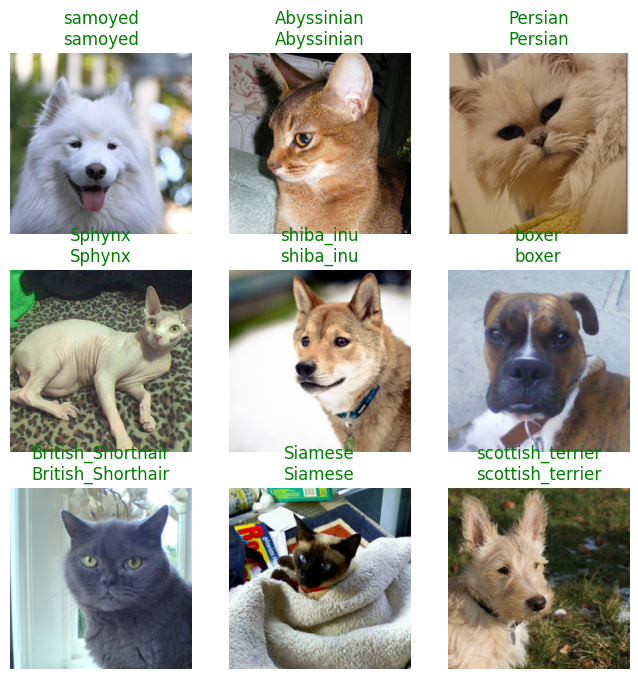

In [10]:
learn.show_results(max_n=9, figsize=(8, 8))

In [11]:
logits = torch.tensor([[2.0, 1.0, 0.1]])
targets = torch.tensor([0])  # True label index

# Apply softmax manually
probs = F.softmax(logits, dim=1)
print("Probabilities:", probs)

# Compute loss manually
loss = F.cross_entropy(logits, targets)
print("Cross-Entropy Loss:", loss)


Probabilities: tensor([[0.6590, 0.2424, 0.0986]])
Cross-Entropy Loss: tensor(0.4170)


In [12]:
xb, yb = dls.one_batch()             # Get one batch (images, labels)
preds = learn.model(xb)              # Raw outputs from model (logits)
preds.shape                          # [batch_size, 37]

torch.Size([64, 37])

In [13]:
probs = F.softmax(preds, dim=1)
probs[0], probs[0].sum()           # View probabilities for first imag

(TensorImage([8.7260e-10, 9.5221e-09, 1.7217e-08, 1.5730e-09, 1.3609e-08,
              1.6604e-08, 4.9271e-09, 4.3881e-09, 2.7002e-11, 1.3856e-09,
              2.3844e-09, 1.2092e-10, 5.1791e-08, 6.9905e-07, 4.2238e-08,
              1.0256e-09, 7.0348e-09, 2.4905e-09, 2.0583e-06, 3.3852e-08,
              3.7658e-07, 1.5153e-05, 6.9266e-08, 3.0851e-08, 6.6004e-08,
              2.9741e-03, 6.6960e-09, 9.9700e-01, 2.3830e-08, 1.1149e-08,
              4.3901e-06, 1.5247e-09, 3.5550e-08, 1.1136e-08, 2.8585e-08,
              5.9952e-09, 4.7978e-09], device='cuda:0',
             grad_fn=<AliasBackward0>),
 TensorImage(1., device='cuda:0', grad_fn=<AliasBackward0>))

✈

**🧠** Model Interpretation: Confusion Matrix & Errors

Use FastAI’s `ClassificationInterpretation` to analyze your trained model:



```python
# Classification
Interpretation
interp = ClassificationInterpretation.from_learner(learn)

# Confusion matrix to see class-wise errors
interp.plot_confusion_matrix(figsize=(12, 12))

# Most wrong + most confident predictions
interp.plot_top_losses(9, nrows=3)

# Most commonly confused pairs of classes
interp.most_confused(min_val=2)


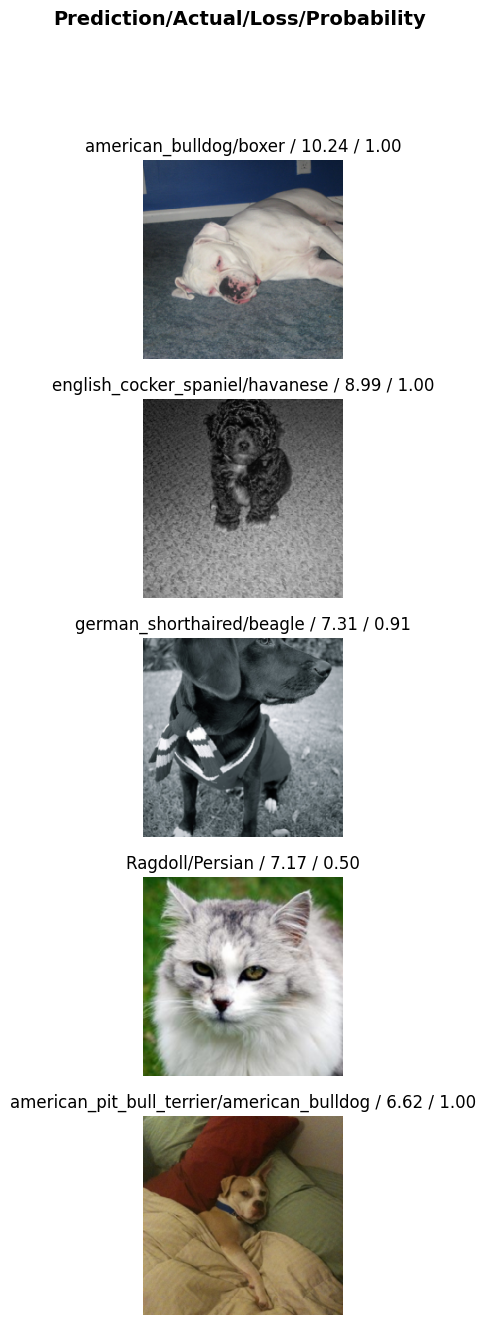

In [14]:
#  Model Interpretation:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, nrows=5)


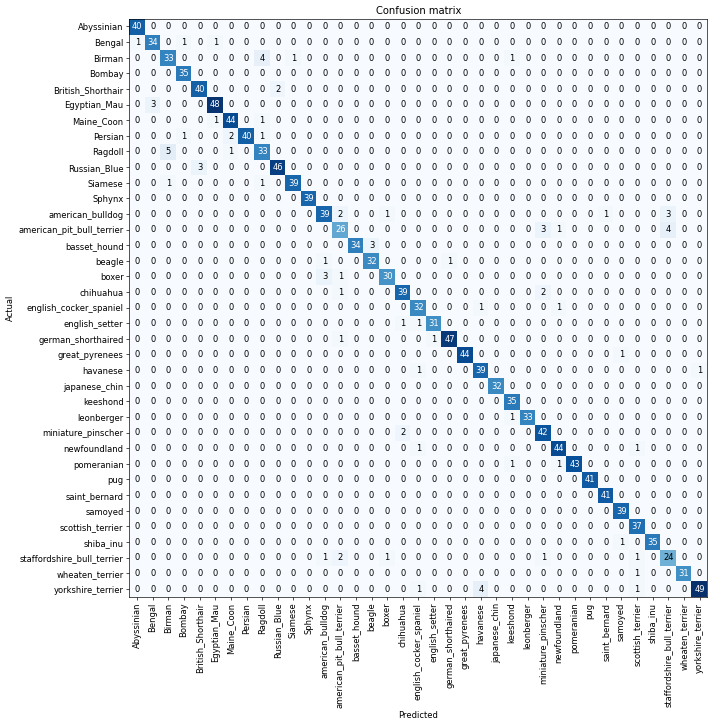

In [18]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [20]:
interp.most_confused(min_val=4)

[('Ragdoll', 'Birman', np.int64(5)),
 ('Birman', 'Ragdoll', np.int64(4)),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', np.int64(4)),
 ('yorkshire_terrier', 'havanese', np.int64(4))]

In [22]:
# Step 1: Train only the head
learn.freeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.068366,0.247751,0.063599,01:03


In [23]:
# Step 2: Unfreeze everything, tune full model
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.078709,0.262011,0.069689,01:05
1,0.083410,0.239499,0.060893,01:06


In [35]:
# How Can You See It’s Working?
how = []
for name, param in learn.model.named_parameters():
    if param.requires_grad:
        how.append((name, param.shape))
how

[('0.0.weight', torch.Size([64, 3, 7, 7])),
 ('0.1.weight', torch.Size([64])),
 ('0.1.bias', torch.Size([64])),
 ('0.4.0.conv1.weight', torch.Size([64, 64, 3, 3])),
 ('0.4.0.bn1.weight', torch.Size([64])),
 ('0.4.0.bn1.bias', torch.Size([64])),
 ('0.4.0.conv2.weight', torch.Size([64, 64, 3, 3])),
 ('0.4.0.bn2.weight', torch.Size([64])),
 ('0.4.0.bn2.bias', torch.Size([64])),
 ('0.4.1.conv1.weight', torch.Size([64, 64, 3, 3])),
 ('0.4.1.bn1.weight', torch.Size([64])),
 ('0.4.1.bn1.bias', torch.Size([64])),
 ('0.4.1.conv2.weight', torch.Size([64, 64, 3, 3])),
 ('0.4.1.bn2.weight', torch.Size([64])),
 ('0.4.1.bn2.bias', torch.Size([64])),
 ('0.4.2.conv1.weight', torch.Size([64, 64, 3, 3])),
 ('0.4.2.bn1.weight', torch.Size([64])),
 ('0.4.2.bn1.bias', torch.Size([64])),
 ('0.4.2.conv2.weight', torch.Size([64, 64, 3, 3])),
 ('0.4.2.bn2.weight', torch.Size([64])),
 ('0.4.2.bn2.bias', torch.Size([64])),
 ('0.5.0.conv1.weight', torch.Size([128, 64, 3, 3])),
 ('0.5.0.bn1.weight', torch.Size([12


**💾 Saving and Loading Models in FastAI**

`FastAI provides two ways to preserve your trained models: saving only the weights, or exporting the full learner for deployment or sharing.`

<sub> Use this when you want to pause and resume training later.<sub/>

```python

#Save the weights:

learn.save('pet-model')
learn.load('pet-model')

#Export the model:
learn.export('pet_model.pkl')

#Load it anywhere later:
from fastai.learner import load_learner

learn = load_learner('pet_model.pkl')
learn.predict('some_image.jpg')
```


**🏗️ Deeper Architectures &⚡Mixed Precision Training**

`🔹 ` <sub>
Swap out the backbone for improved accuracy:
<sub/>



```python
# Try a Deeper Model
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(4)

# Enable Mixed Precision for Speed & Memory Efficiency => Use float16 training for faster performance:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(4)

```

## ...Notes

### 🚀 ImageDataLoaders.from_name_func



`ImageDataLoaders.from_name_func` is a FastAI shortcut that quickly builds a `DataLoaders` object for image classification tasks using:

- A list of image file paths
- A labeling function (`func`) that extracts the label from each file
- Optional transforms and parameters

---



```python
# 🧱 Syntax
ImageDataLoaders.from_name_func(
    path,                    # Root folder
    fnames,                  # List of image paths
    label_func,              # Function to extract label from file
    valid_pct=0.2,           # Validation set split
    seed=42,                 # Seed for reproducibility
    item_tfms=Resize(460),   # Presizing
    batch_tfms=aug_transforms(size=224)  # Augmentations
)


In [27]:
def label_func(fname): return re.search(pat, Path(fname).name).group(1)

idls = ImageDataLoaders.from_name_func(
    path,
    fnames,
    label_func,
    valid_pct=0.2, seed=42,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224)
)

### 🌀 Presizing & Data Augmentation tip

🔧 Transform Parameters


| Transform         | Parameter           | Example                      | Description                                 |
|------------------|---------------------|------------------------------|---------------------------------------------|
| Resize Size       | `Resize(460)`       | `item_tfms=Resize(460)`      | Resize each image to a larger square        |
| Final Input Size  | `size=224`          | `aug_transforms(size=224)`   | Random crop to model input size             |
| Zoom Range        | `min_scale`         | `min_scale=0.5`              | Zoom into images (lower = more zoom)        |
| Rotation          | `max_rotate`        | `max_rotate=20`              | Rotate image randomly                       |
| Lighting Adjust   | `max_lighting`      | `max_lighting=0.4`           | Vary brightness/contrast                    |
| Warp Effect       | `max_warp`          | `max_warp=0.2`               | Geometric warping                           |
| Padding Mode      | `pad_mode='zeros'`  | `Resize(224, pad_mode='zeros')` | Use zero padding instead of crop         |
| Normalization     | `Normalize.from_stats(...)` | `batch_tfms=[..., Normalize.from_stats(*imagenet_stats)]` | Normalize based on pretrained weights |

---
<br>


## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods that it adds.
1. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a `DataLoaders`?
1. What method does fastai provide to help you debug a `DataBlock`?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross-entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the `fine_tune` method do?
1. In Jupyter Notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
1. Why is early stopping a poor choice when using 1cycle training?
1. What is the difference between `resnet50` and `resnet101`?
1. What does `to_fp16` do?

Answeraire

---

1. **Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?**  
   To minimize distortion and preserve aspect ratio, images are first resized to a larger square on the CPU. Then a centered crop is applied on the GPU, which is much faster and allows efficient batching during training.

2. **If you are not familiar with regular expressions...**  
   (Suggestion for later) Use [regexone.com](https://regexone.com) or [regex101.com](https://regex101.com) to practice.

3. **What are the two ways in which data is most commonly provided, for most deep learning datasets?**  
   - As a folder of files with names/paths indicating labels  
   - As a structured table (like a CSV) with filenames and labels in columns

4. **Look up the documentation for `L`...**  
   The `L` class is a FastAI enhanced list with methods like `.map()`, `.filter()`, `.zip()`, `.unique()`, `.sorted()`, `.itemgot()` for powerful transformations.

5. **Look up the documentation for `pathlib`...**  
   The `Path` class offers methods like `.ls()`, `.glob()`, `.name`, `.suffix`, `.parent`, and can be used to navigate and manipulate filesystem paths easily.

6. **Give two examples of ways that image transformations can degrade the quality of the data.**  
   - Excessive zoom or cropping might cut out relevant features  
   - Rotations or flips could mislead the model for asymmetric objects (e.g., text or animal faces)

7. **What method does fastai provide to view the data in a `DataLoaders`?**  
   `dls.show_batch()` shows a mini-batch of inputs and labels visually.

8. **What method does fastai provide to help you debug a `DataBlock`?**  
   `pets.summary(path)` (where `pets` is your DataBlock) shows how items flow through the pipeline.

9. **Should you hold off on training a model until you have thoroughly cleaned your data?**  
   No. Train early and often to surface problems. FastAI encourages iterative data cleaning using tools like `ClassificationInterpretation`.

10. **What are the two pieces that are combined into cross-entropy loss in PyTorch?**  
   - `LogSoftmax` (log-probabilities)  
   - `Negative Log Likelihood` (compares with target class index)

11. **What are the two properties of activations that softmax ensures? Why is this important?**  
   - All outputs are between 0 and 1  
   - Outputs sum to 1  
   This turns raw scores into probabilities, allowing comparison and loss calculation.

12. **When might you want your activations to not have these two properties?**  
   In multi-label classification or regression tasks where outputs aren't mutually exclusive or don't need to sum to 1.

13. **Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself...**  
   (Do this manually in notebook or spreadsheet; involves applying exp to logits, then dividing each by the sum of all exp values)

14. **Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?**  
   Because `torch.where` is binary. It only selects between two options based on a condition, unsuitable for multiclass labels.

15. **What is the value of log(-2)? Why?**  
   Undefined (or NaN). The logarithm of a negative number is not defined in the real number space.

16. **What are two good rules of thumb for picking a learning rate from the learning rate finder?**  
   - Pick the steepest point just before the loss rises  
   - Avoid flat regions or sharp upward slopes

17. **What two steps does the `fine_tune` method do?**  
   - Trains only the head (frozen pretrained model) for 1 epoch  
   - Then unfreezes and trains the entire model

18. **In Jupyter Notebook, how do you get the source code for a method or function?**  
   Use `??` after the function name, e.g., `learn.fit_one_cycle??`

19. **What are discriminative learning rates?**  
   Different learning rates applied to different layers: lower for early (general) layers, higher for late (task-specific) ones.

20. **How is a Python `slice` object interpreted when passed as a learning rate to fastai?**  
   It applies the low end of the slice to the earliest layers, and the high end to the last layers.

21. **Why is early stopping a poor choice when using 1cycle training?**  
   1cycle training intentionally increases LR toward the end to improve generalization. Early stopping may halt training before this happens.

22. **What is the difference between `resnet50` and `resnet101`?**  
   `resnet101` has more layers than `resnet50`, making it deeper and potentially more accurate, but slower.

23. **What does `to_fp16` do?**  
   Converts model to use float16 (mixed precision), reducing memory usage and improving speed on supported GPUs.


### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.